<a href="https://colab.research.google.com/github/JunEden/Tensorflow/blob/main/%E3%80%8C%E5%9C%96%E5%BD%A2%E5%91%88%E7%8F%BE_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用套件

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.layers import Dropout

# preprocess_input 這邊引用用各自模型
from tensorflow.keras.applications.mobilenet import preprocess_input as M_pre_input
from tensorflow.keras.applications.xception import preprocess_input as X_pre_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_pre_input

# from tensorflow import *
#from tensorflow.keras.preprocessing import image 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 模型架構與讀取weights

## - 俊辰 model1

In [ ]:
# 放模型構架
cnn_M = MobileNet(include_top=False, input_shape=(224, 224, 3))
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model1 = Sequential(cnn_M.layers + layers)

# 直接Load model 不用家變量  讀取 weights
model1.load_weights('/content/drive/MyDrive/Model_Test/mobileNet_Vol.3.h5')

## - 宗驛 model2

In [ ]:
cnn_X = Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
# cnn_X.summary()
# 卷積模型不參與訓練，要在 compile 前設定好
for l in cnn_X.layers:
  l.trainable = False

# 加上自己的網路層
x = cnn_X.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x) 

model2 = Model(cnn_X.input, output)
#model_X.summary()  # Trainable params: 8,194 = 2048*2 + ( 2048*2+2 )

# 讀取 weights
model2.load_weights("/content/drive/MyDrive/Model_Test/poo_zoy_X1weights.h5")

83697664/83683744 [==============================] - 1s 0us/step


## - 君源 model3

In [ ]:
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))

for l in cnn.layers:
    l.trainable = False

layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model3 = Sequential(cnn.layers + layers)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# 讀取 weights
model3.load_weights("/content/drive/MyDrive/Model_Test/poo_mike_v3weights.h5")

# 讀取測試照片集20張(正常:10/不正常:10)

In [ ]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/Model_Test/TestIMG.zip")
f.extractall()

In [ ]:
picG = glob.glob("TestIMG/good*") # 10張正常
picB = glob.glob("TestIMG/bad*") # 10張不正常

x_test = np.array(picG + picB)
y_test = np.array([0] * len(picG) + [1] * len(picB))

print(x_test.shape)
print(y_test.shape)

(20,)
(20,)


# 進行測試資料前處理

## for 俊辰

In [ ]:
ori_imgs1 = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs1.append(np.array(img))
ori_imgs1 = np.array(ori_imgs1)
preprocess_imgs1 = M_pre_input(ori_imgs1)

## for 宗驛

In [ ]:
ori_imgs2 = []
for p in x_test:
    img = Image.open(p).resize((299, 299)).convert("RGB")
    ori_imgs2.append(np.array(img))
ori_imgs2 = np.array(ori_imgs2)
preprocess_imgs2 = X_pre_input(ori_imgs2)

## for 君源

In [ ]:
ori_imgs3 = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs3.append(np.array(img))
ori_imgs3 = np.array(ori_imgs3)
preprocess_imgs3 = vgg16_pre_input(np.array(ori_imgs3))

# 模型預測數據

## Recall & Precision 

In [ ]:
# 三個模型預測
pre1 = model1.predict(preprocess_imgs1).argmax(axis=1)
pre2 = model2.predict(preprocess_imgs2).argmax(axis=1)
pre3 = model3.predict(preprocess_imgs3).argmax(axis=1)

print(classification_report(y_test, pre1)) # Model1 - MobileNet
print(classification_report(y_test, pre2)) # Model2 - Xception
print(classification_report(y_test, pre3)) # Model3 - VGG16

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20

              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.80      0.40      0.53        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



## Confusion Matrix 混淆矩陣

In [ ]:
# 計算『混淆矩陣』(Confusion Matrix)，顯示測試集分類的正確及錯認總和數
 
df1 = pd.crosstab(y_test, pre1, rownames=['實際值'], colnames=['預測值'])
df2 = pd.crosstab(y_test, pre2, rownames=['實際值'], colnames=['預測值'])
df3 = pd.crosstab(y_test, pre3, rownames=['實際值'], colnames=['預測值'])

In [ ]:
df1 # Model1 - MobileNet

預測值,0,1
實際值,,
0,8,2
1,4,6


In [ ]:
df2 # Model2 - Xception

預測值,0,1
實際值,,
0,9,1
1,6,4


In [ ]:
df3 # Model3 - VGG16

預測值,0,1
實際值,,
0,10,0
1,5,5


## ROC 曲線與 AUC

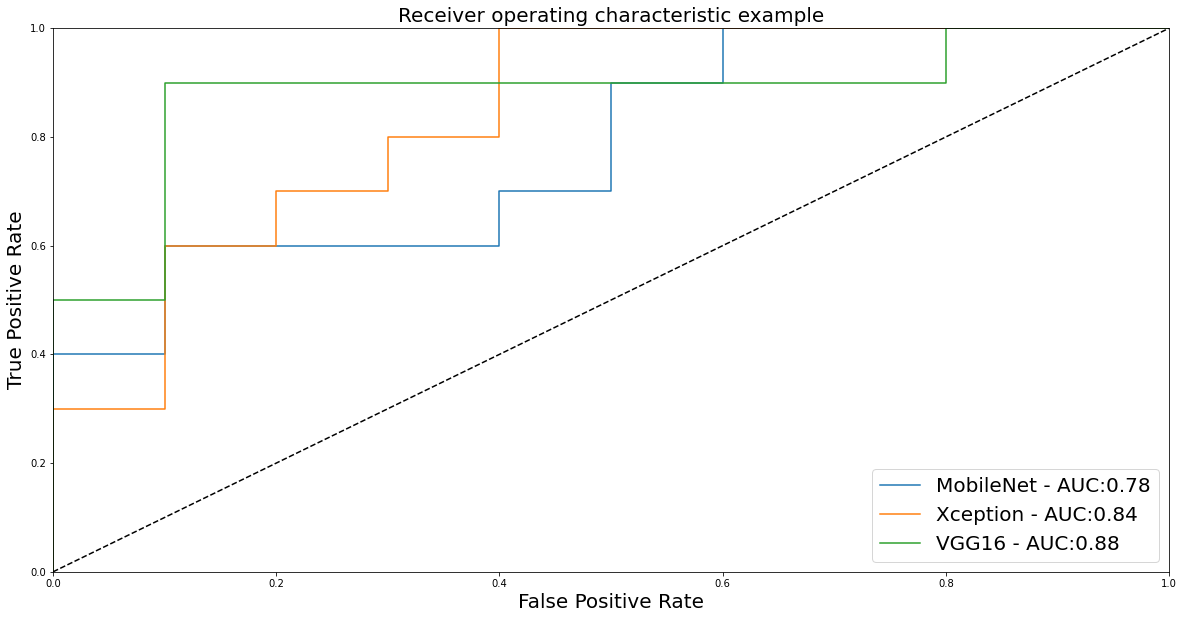

In [ ]:
plt.figure(figsize= [20,10])

for m, title, preimg in zip([model1, model2, model3], ['MobileNet', 'Xception', 'VGG16'],
            [preprocess_imgs1, preprocess_imgs2, preprocess_imgs3]):
  prob = m.predict(preimg)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, prob)
  plt.plot(fpr, tpr, label='%s - AUC:%.2f'%(title, auc(fpr, tpr)))

plt.legend(loc="lower right", fontsize = 20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver operating characteristic example', fontsize = 20)
plt.show()

# 圖片預測結果內容

In [ ]:
trans = ["good", "Bad"]

## - 俊辰

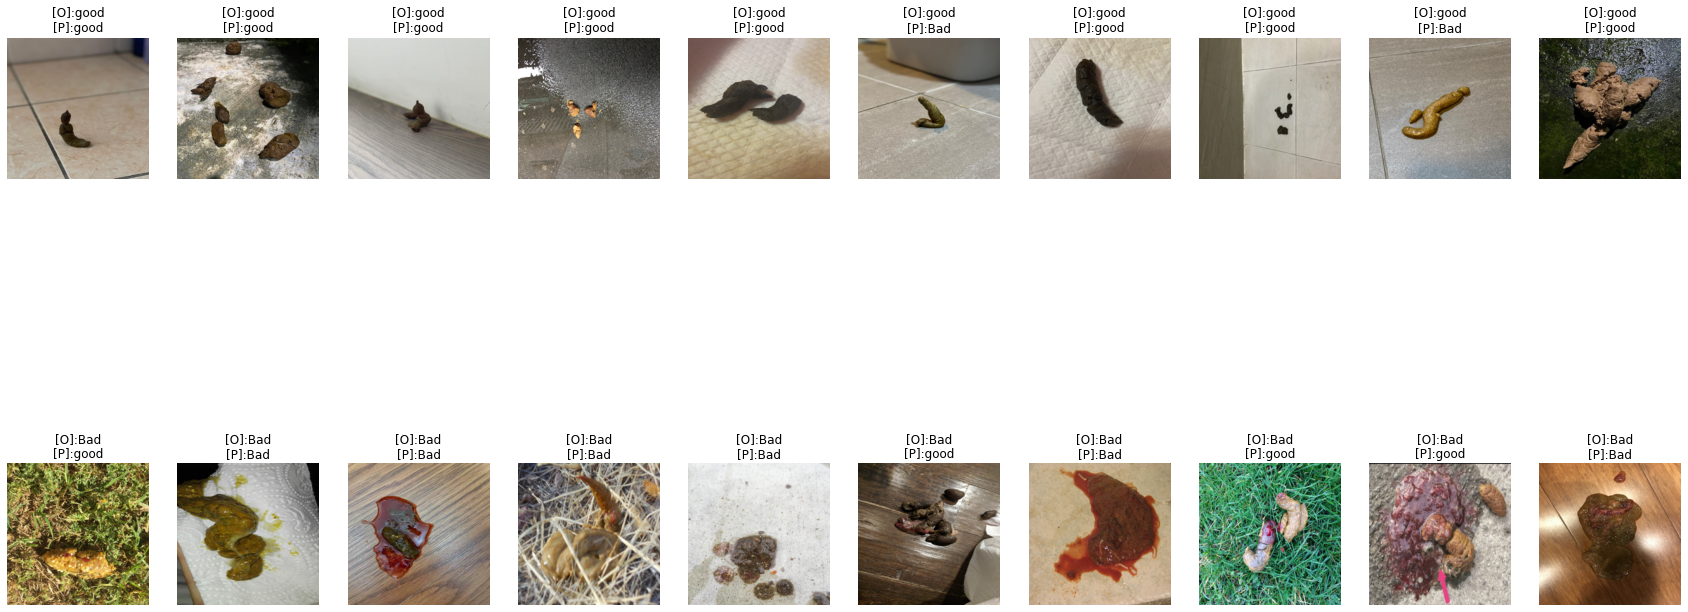

In [ ]:
pre_img1 = ori_imgs1[:]
pre_val1 = pre1[:]
pre_ori1 = y_test[:]

plt.figure(figsize=(30, 30))
width = 10
height = 30 // width + 1
for i in range(20):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_ori1[i]], trans[pre_val1[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_img1[i])

In [ ]:
model1.predict(preprocess_imgs1)

array([[5.3014523e-01, 4.6985480e-01],
       [8.2082915e-01, 1.7917088e-01],
       [6.9610316e-01, 3.0389684e-01],
       [6.3709998e-01, 3.6290002e-01],
       [9.1917098e-01, 8.0829002e-02],
       [4.9360749e-01, 5.0639254e-01],
       [7.8584772e-01, 2.1415223e-01],
       [9.8592454e-01, 1.4075394e-02],
       [1.6353662e-01, 8.3646333e-01],
       [9.9766243e-01, 2.3376192e-03],
       [7.9532975e-01, 2.0467025e-01],
       [1.2764990e-01, 8.7235016e-01],
       [1.7637210e-01, 8.2362789e-01],
       [5.0696332e-02, 9.4930363e-01],
       [4.3111435e-01, 5.6888562e-01],
       [6.7869830e-01, 3.2130170e-01],
       [4.1717893e-04, 9.9958283e-01],
       [7.3751312e-01, 2.6248688e-01],
       [6.9862372e-01, 3.0137634e-01],
       [1.6484177e-02, 9.8351580e-01]], dtype=float32)

## - 宗驛

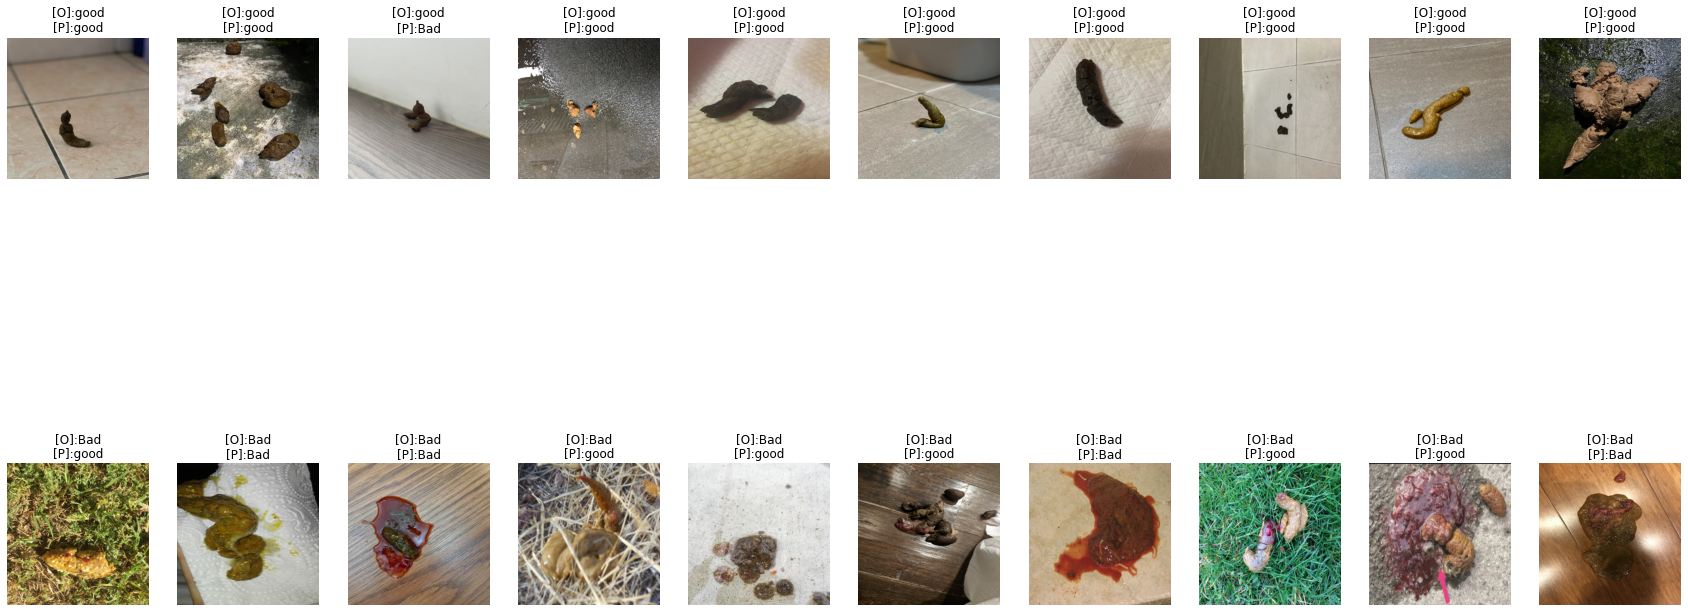

In [ ]:
pre_img2 = ori_imgs2[:]
pre_val2 = pre2[:]
pre_ori2 = y_test[:]

plt.figure(figsize=(30, 30))
width = 10
height = 30 // width + 1
for i in range(20):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_ori2[i]], trans[pre_val2[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_img2[i])

In [ ]:
model2.predict(preprocess_imgs2)

array([[0.97180724, 0.02819276],
       [0.93967897, 0.0603211 ],
       [0.41444623, 0.58555377],
       [0.9777099 , 0.02229008],
       [0.56079155, 0.43920848],
       [0.9558668 , 0.04413313],
       [0.9502623 , 0.04973761],
       [0.69088775, 0.30911225],
       [0.84690887, 0.15309112],
       [0.9735988 , 0.02640122],
       [0.51012045, 0.48987955],
       [0.25934148, 0.7406585 ],
       [0.19453923, 0.80546075],
       [0.8185462 , 0.18145384],
       [0.5521569 , 0.44784302],
       [0.8945546 , 0.10544541],
       [0.08844148, 0.9115585 ],
       [0.9381505 , 0.0618495 ],
       [0.6643282 , 0.33567172],
       [0.45438242, 0.5456176 ]], dtype=float32)

## - 君源

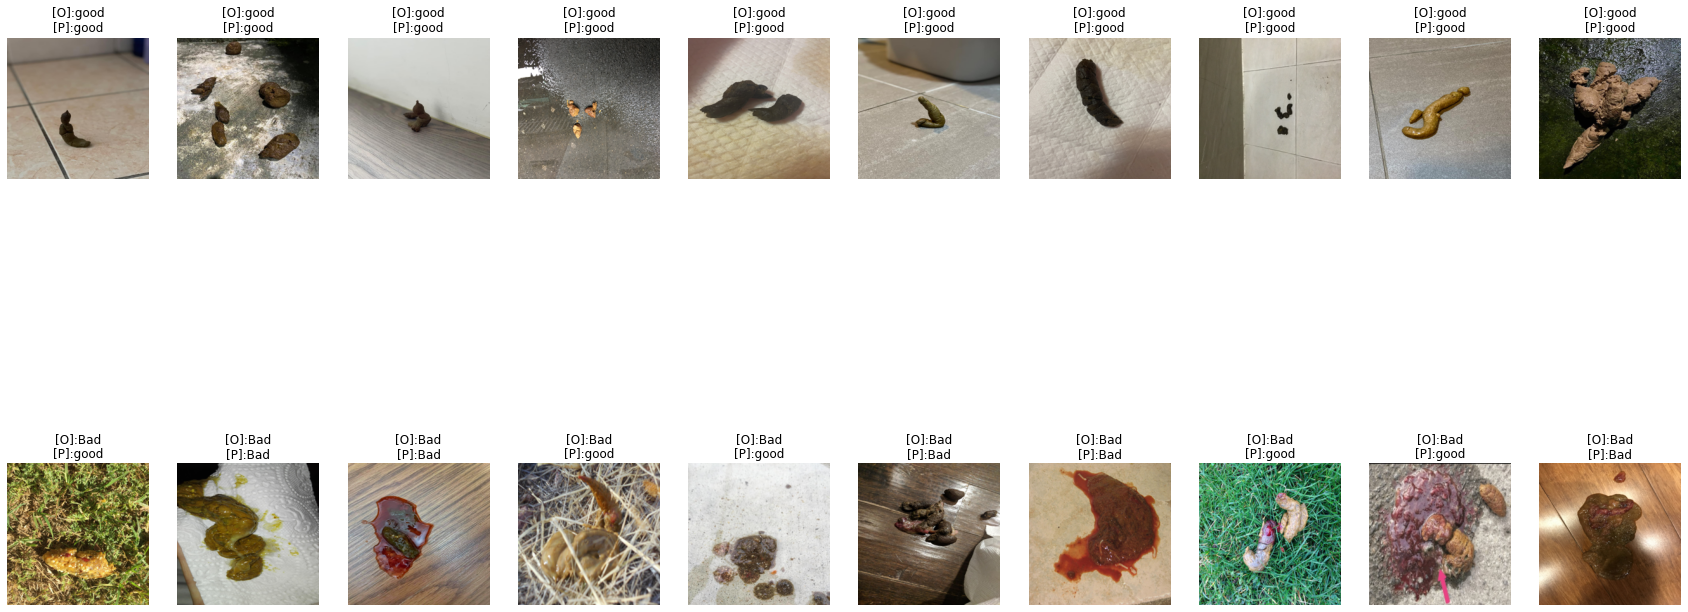

In [ ]:
pre_img3 = ori_imgs3[:]
pre_val3 = pre3[:]
pre_ori3 = y_test[:]

plt.figure(figsize=(30, 30))
width = 10
height = 30 // width + 1
for i in range(20):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_ori3[i]], trans[pre_val3[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_img3[i])

In [ ]:
model3.predict(preprocess_imgs3)

array([[0.8085497 , 0.19145025],
       [0.992712  , 0.00728797],
       [0.5291114 , 0.47088864],
       [0.9919545 , 0.0080455 ],
       [0.7732908 , 0.22670911],
       [0.86640215, 0.13359782],
       [0.8007829 , 0.1992171 ],
       [0.7469893 , 0.25301066],
       [0.77569497, 0.22430502],
       [0.95702213, 0.04297784],
       [0.64998525, 0.35001472],
       [0.03349954, 0.9665004 ],
       [0.01297338, 0.98702663],
       [0.6223206 , 0.37767944],
       [0.6178695 , 0.38213044],
       [0.46492127, 0.5350787 ],
       [0.07678204, 0.923218  ],
       [0.98017967, 0.01982034],
       [0.7249561 , 0.27504396],
       [0.19347167, 0.8065283 ]], dtype=float32)